In [538]:
#!pip install numpy pandas scikit-learn nltk spacy mlflow chardet contractions

In [539]:
#!python -m spacy download en_core_web_sm

In [540]:
#conda install -c conda-forge scikit-learn imbalanced-learn

In [541]:
#pip install catboost

# 1. Charger librairies

In [542]:
# Imports standards de Python
import os
import re
import string
import time
from collections import Counter
import warnings

# Imports de bibliothèques tierces
import chardet
import mlflow
import mlflow.sklearn
import nltk
import numpy as np
import pandas as pd
import spacy
import contractions

# Imports de NLTK
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Imports de scikit-learn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, f1_score, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.naive_bayes import ComplementNB, MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier


# Imports de MLflow
from mlflow.models.signature import infer_signature

# Téléchargements NLTK
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

# Chargement du modèle spaCy
nlp = spacy.load("en_core_web_sm")

# Configuration globale 
warnings.filterwarnings("ignore", category=UserWarning, module="mlflow")

stop_words = set(stopwords.words('english'))

mlflow.set_experiment("BBC Sports Articles Classification")


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/claudia.abad/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/claudia.abad/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/claudia.abad/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/claudia.abad/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<Experiment: artifact_location='file:///Users/claudia.abad/Formation%20IA/A56/TPs/TPA56-BbcSports/mlruns/595029885274379098', creation_time=1741641509618, experiment_id='595029885274379098', last_update_time=1741641509618, lifecycle_stage='active', name='BBC Sports Articles Classification', tags={}>

# 2. Chargement des données
Lecture des fichiers texte :

In [543]:
pd.set_option('display.max_colwidth', None)

def detect_encoding(file_path):
    with open(file_path, "rb") as f:
        raw_data = f.read()
    result = chardet.detect(raw_data)
    return result["encoding"]

def generer_dataset(dossier_principal: str = 'bbcsport'):
    df = pd.DataFrame(columns=["sport", "text"])

    for nom_dossier in os.listdir(dossier_principal):
        chemin_dossier = os.path.join(dossier_principal, nom_dossier)
        
        if os.path.isdir(chemin_dossier):
            for nom_fichier in os.listdir(chemin_dossier):
                chemin_fichier = os.path.join(chemin_dossier, nom_fichier)
                
                if nom_fichier.endswith(".txt"):
                    encoding = detect_encoding(chemin_fichier)
                    with open(chemin_fichier, "r", encoding=encoding) as fichier:
                        contenu = fichier.read()
                    
                    nouvelle_ligne = {"sport": nom_dossier, "text": contenu}
                    df = pd.concat([df, pd.DataFrame([nouvelle_ligne])], ignore_index=True)

    return df

df = generer_dataset()

df = df.sample(frac=1, random_state=11).reset_index(drop=True)
    
df

sport  \
0        rugby   
1    athletics   
2        rugby   
3    athletics   
4    athletics   
..         ...   
732    cricket   
733    cricket   
734   football   
735   football   
736     tennis   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 text  
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  Lewsey puzzle over disallowed try\n\nEngland's Josh Lewsey has claimed he was denied a late try in his side's Six Nations loss to Ireland.\n\nThe Wasps wing insisted he grounded the ball when he was bundled over the line and said referee Jonathan Kaplan had made a wrong decisi

# 3 . Analyse Exploratoire de données

- **Statistiques descriptives** :
  - Nombre total de documents.
  - Longueur moyenne des textes par catégorie.
  - Distribution des catégories (visualisation avec Matplotlib/Seaborn).
- **Analyse textuelle** :
  - Fréquence des mots par catégorie (utiliser `TextHero` ou `CountVectorizer`).
  - Nuages de mots (`wordcloud`) pour chaque catégorie.

In [544]:
total_documents = df.shape[0]
print(f"Nombre total de documents : {total_documents}")

Nombre total de documents : 737


In [545]:
# Chercher doublons
duplicates_by_text = df[df.duplicated(subset=['text'], keep=False)]
display(duplicates_by_text)

sport  \
42    football   
63   athletics   
96   athletics   
122      rugby   
174  athletics   
194     tennis   
203    cricket   
212   football   
248   football   
265      rugby   
286    cricket   
355    cricket   
375   football   
383  athletics   
429    cricket   
483   football   
495     tennis   
511    cricket   
704   football   
733    cricket   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           text  
42                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [546]:
# Effacer doublons
df = df.drop_duplicates(subset=['text', 'sport'], keep='first')

In [547]:
# Analyse statistique des textes

pd.reset_option('display.max_colwidth')

def calculer_entropie(text):
    mots = text.split()
    compteur = Counter(mots)
    probas = [freq / len(mots) for freq in compteur.values()]
    return -np.sum(probas * np.log2(probas))

def extra_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()  # Crée une copie explicite pour éviter le warning

    df["num_lignes"] = df["text"].map(lambda text: text.count("\n\n"))  
    df["text"] = df["text"].map(lambda text: text.replace("\n\n", " "))

    df.loc[:, 'longueur_texte'] = df['text'].apply(len)
    df.loc[:, 'num_mots'] = df['text'].map(lambda x: len(x.split()))
    df.loc[:, 'num_caracteres_avec_espaces'] = df['text'].map(lambda x: len(x))
    df.loc[:, 'longueur_moyenne_mots'] = df['text'].map(lambda x: sum(len(word) for word in x.split()) / len(x.split()) if len(x.split()) > 0 else 0)
    df.loc[:, 'stopwords'] = df['text'].map(lambda x: len([z for z in x.split() if z in stop_words]))
    df.loc[:, 'mots_chiffres'] = df['text'].map(lambda x: len([z for z in x.split() if z.isdigit()]))
    df.loc[:, 'entropie'] = df['text'].apply(calculer_entropie)
    df.loc[:, 'richesse_lexicale'] = df['text'].apply(lambda x: len(set(x.split())) / len(x.split()) if len(x.split()) > 0 else 0)
    df.loc[:, 'mots_uniques'] = df['text'].apply(lambda x: len(set(x.split())))
    df.loc[:, 'nombre_majuscules'] = df['text'].apply(lambda x: sum(1 for mot in x.split() if mot.istitle()))
    df.loc[:, 'nombre_ponctuations'] = df['text'].apply(lambda x: sum(1 for char in x if char in string.punctuation))

    return df

df = extra_features(df)

df

sport                                               text  num_lignes  \
0        rugby  Lewsey puzzle over disallowed try England's Jo...           3   
1    athletics  McIlroy continues winning streak James McIlroy...           2   
2        rugby  Captains lining up for Aid match Ireland's Bri...           4   
3    athletics  Holmes is hit by hamstring injury Kelly Holmes...           3   
4    athletics  Greene to compete in Birmingham Maurice Greene...           3   
..         ...                                                ...         ...   
731    cricket  Batting prospects excite Vaughan England skipp...           3   
732    cricket  Shoaib ruled out of Test series Fast bowler Sh...           3   
734   football  Benitez deflects blame from Dudek Liverpool ma...           2   
735   football  England's defensive crisis grows England's def...           3   
736     tennis  Rusedski angry over supplements Greg Rusedski ...           4   

     longueur_texte  num_mots  num_caracteres_avec_espaces  \
0              1224       227                         1224   
1              1222       203                         1222   
2              1823       298                         1823   
3              1413       256                         1413   
4               961       159                          961   
..              ...       ...                          ...   
731            1767       305                         1767   
732            2358       414                         2358   
734            1073       191                         1073   
735            1328       221                         1328   
736            1763       305                         1763   

     longueur_moyenne_mots  stopwords  mots_chiffres  entropie  \
0                 4.392070         93              0  6.834080   
1                 5.019704         70              0  6.863443   
2                 5.117450         55              1  7.388641   
3                 4.519531        115              1  7.045083   
4                 5.044025         51              1  6.499336   
..                     ...        ...            ...       ...   
731               4.793443        140              0  6.993604   
732               4.695652        172              4  7.317432   
734               4.617801         87              0  6.745524   
735               5.009050         90              0  6.915576   
736               4.780328        137              0  7.213278   

     richesse_lexicale  mots_uniques  nombre_majuscules  nombre_ponctuations  
0             0.660793           150                 34                   46  
1             0.709360           144                 26                   34  
2             0.667785           199                180                  158  
3             0.652344           167                 42                   31  
4             0.716981           114                 37                   29  
..                 ...           ...                ...                  ...  
731           0.593443           181                 53                   40  
732           0.570048           236                 61                   51  
734           0.670157           128                 32                   32  
735           0.674208           149                 48                   29  
736           0.652459           199                 37                   48  

[727 rows x 14 columns]

sport
football     262
rugby        146
cricket      121
athletics     99
tennis        99
Name: count, dtype: int64


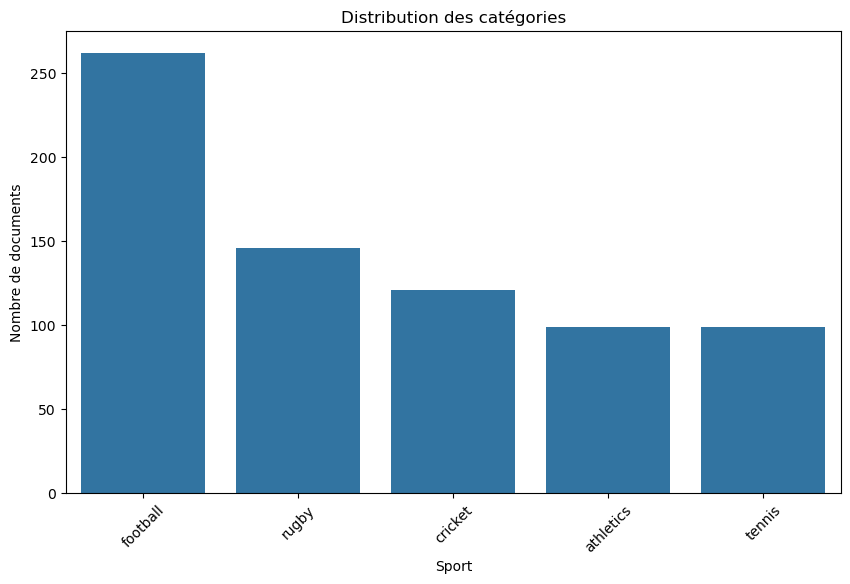

In [548]:
import matplotlib.pyplot as plt
import seaborn as sns

# Vérifier la nouvelle distribution
print(df['sport'].value_counts())

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='sport', order=df['sport'].value_counts().index)
plt.title('Distribution des catégories')
plt.xlabel('Sport')
plt.ylabel('Nombre de documents')
plt.xticks(rotation=45)
plt.show()

La classe footbal est beaucoup plus représentée que les autres, donc on décide d'appliquer un Undersampling sur cette catégorie majoritaire.

# 4 . Prétraitement des données
Nettoyage du texte :

* Fixer les contractions de l'anglais, supprimer la ponctuation, les stopwords, les caractères spéciaux.

* Convertir le texte en minuscules.

* Lemmatisation

In [549]:
def nettoyer_texte(df, colonne_texte):
    
    # pour éviter les warnings
    df = df.copy()
    
    def nettoyer_texte_unique(texte):
        texte = contractions.fix(texte)  # Expandir les contractions ex It's par It is
        texte = re.sub(r'\s+', ' ', texte).strip()  # Supprime les espaces en double et les espaces en début/fin
        texte = re.sub(r'[^\w\s]', '', texte) # Supprimez la ponctuation mais conservez les mots et les chiffres
        texte = texte.lower()  # Convertir en minuscules
        tokens = word_tokenize(texte)  # Tokenisation
        tokens = [token for token in tokens if token not in stop_words]  # Supprimer les stopwords
        return ' '.join(tokens)
    
    df.loc[:, 'texte_nettoye'] = df[colonne_texte].apply(nettoyer_texte_unique)

    return df

df = nettoyer_texte(df, "text")

df


sport                                               text  num_lignes  \
0        rugby  Lewsey puzzle over disallowed try England's Jo...           3   
1    athletics  McIlroy continues winning streak James McIlroy...           2   
2        rugby  Captains lining up for Aid match Ireland's Bri...           4   
3    athletics  Holmes is hit by hamstring injury Kelly Holmes...           3   
4    athletics  Greene to compete in Birmingham Maurice Greene...           3   
..         ...                                                ...         ...   
731    cricket  Batting prospects excite Vaughan England skipp...           3   
732    cricket  Shoaib ruled out of Test series Fast bowler Sh...           3   
734   football  Benitez deflects blame from Dudek Liverpool ma...           2   
735   football  England's defensive crisis grows England's def...           3   
736     tennis  Rusedski angry over supplements Greg Rusedski ...           4   

     longueur_texte  num_mots  num_caracteres_avec_espaces  \
0              1224       227                         1224   
1              1222       203                         1222   
2              1823       298                         1823   
3              1413       256                         1413   
4               961       159                          961   
..              ...       ...                          ...   
731            1767       305                         1767   
732            2358       414                         2358   
734            1073       191                         1073   
735            1328       221                         1328   
736            1763       305                         1763   

     longueur_moyenne_mots  stopwords  mots_chiffres  entropie  \
0                 4.392070         93              0  6.834080   
1                 5.019704         70              0  6.863443   
2                 5.117450         55              1  7.388641   
3                 4.519531        115              1  7.045083   
4                 5.044025         51              1  6.499336   
..                     ...        ...            ...       ...   
731               4.793443        140              0  6.993604   
732               4.695652        172              4  7.317432   
734               4.617801         87              0  6.745524   
735               5.009050         90              0  6.915576   
736               4.780328        137              0  7.213278   

     richesse_lexicale  mots_uniques  nombre_majuscules  nombre_ponctuations  \
0             0.660793           150                 34                   46   
1             0.709360           144                 26                   34   
2             0.667785           199                180                  158   
3             0.652344           167                 42                   31   
4             0.716981           114                 37                   29   
..                 ...           ...                ...                  ...   
731           0.593443           181                 53                   40   
732           0.570048           236                 61                   51   
734           0.670157           128                 32                   32   
735           0.674208           149                 48                   29   
736           0.652459           199                 37                   48   

                                         texte_nettoye  
0    lewsey puzzle disallowed try englands josh lew...  
1    mcilroy continues winning streak james mcilroy...  
2    captains lining aid match irelands brian odris...  
3    holmes hit hamstring injury kelly holmes force...  
4    greene compete birmingham maurice greene go he...  
..                                                 ...  
731  batting prospects excite vaughan england skipp...  
732  shoaib ruled test series fast bowler shoaib ak...  
734  benitez deflects bl

In [550]:
pd.set_option('display.max_colwidth', None)

def apply_stemming(df, text_column, new_column_name="stemmed_text"):
    stemmer = PorterStemmer()
    
    def stem_text(text):
        tokens = word_tokenize(text)  # Tokenisation du texte
        stemmed_tokens = [stemmer.stem(token) for token in tokens]  # Stemming
        return " ".join(stemmed_tokens)  # Rejoindre les tokens en une chaîne
    
    df[new_column_name] = df[text_column].apply(stem_text)
    return df

def apply_lemmatization_nltk(df, text_column, new_column_name="lemmatized_text"):
    
    lemmatizer = WordNetLemmatizer()
    
    def lemmatize_text(text):
        tokens = word_tokenize(text)  # Tokenisation du texte
        lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]  # Lemmatisation
        return " ".join(lemmatized_tokens)  # Rejoindre les tokens en une chaîne
    
    df[new_column_name] = df[text_column].apply(lemmatize_text)
    return df

# Appliquer le stemming
df = apply_stemming(df, text_column="texte_nettoye", new_column_name="stemmed_text")

# Appliquer la lemmatisation avec NLTK
df = apply_lemmatization_nltk(df, text_column="texte_nettoye", new_column_name="lemmatized_text_nltk")

df[["text","texte_nettoye", "stemmed_text", "lemmatized_text_nltk"]].head()

# 
#df.iloc[17]


text  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         Lewsey puzzle over disallowed try England's Josh Lewsey has claimed he was denied a late try in his side's Six Nations loss to Ireland. The Wasps wing insisted he grounded the ball when he was bundled over the line and said referee Jonathan Kaplan had made a wrong decision. "I'm positive I touched the ball down over the line," Lewsey told BBC Sport. "It certainly wasn't a turnover. "I was driven over and I put the ball on the ground. The whistle went and I let go of the ball." Lewsey added: "One of the Irish players scooped it back after the whistle and to our surprise the referee then gave a turnover. "As far as I'm concerned, that incident and Mark Cueto's effort from Charlie Hodgson's cross-field kick that led to what looked like a good try were the two key elements in the game." Cueto was also puzzled as to why his try had been disallowed by Kaplan. "I don't think I could have been offside for, without a doubt, I was behind the ball," said the Sale player. "The move was a planned technique, it was not off the cuff. We rehearse it time and time again. "I wouldn't say we were robbed, some decisions go with you and some go against you. Today they went against us and that's tough at international level."\n   
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           McIlroy continues winning streak James McIlroy stormed to his second international victory in less than a week, claiming the men's 800m at the TEAG indoor meeting in Erfurt. The Northern Ireland runner set a new personal best of one minute, 46.68 seconds - a time good enough to qualify for the European Indoor Championships. "I'm qualified now and that's what matters most," said the 28-year-old. McIlroy is now hoping to gain a late entry into Sunday's international indoor meeting in Leipzig. The Northern Irishman is hoping manager Ricky Simms can swing it for him to compete after he initially withdrew after contracting a cold. After three successive wins over the past fortnight, McIlroy is brimming with confidence. "I've been waiting over six years for this to happen and now I'm certain my career has turned the corner." On Friday, McIlroy delivered an impressive run despite suffering from his bad cold. The AAA indoor and outdoor champion accelerated away from the field in the final 300m, beating German Wolfram Mulle by 0.90 seconds. McIlroy set a world-leading mark for 1,000m at the Sparkassen Cup in Stuttgart last weekend. And his time in Erfurt makes him third fastest over 800m in the world this year.\n   
2  Captains lining up for Aid match Ireland's Brian O'Driscoll is one of four Six Nations captains included in the Northern Hemisphere squad for the IRB Rugby Aid match on 5 March. France's Fabien Pelous, Gordon Bullock of Scotland and Italy's Marco Bortolami are also in the Northern party. Sir Clive Woodward will coach the Nort

Remarques
Stemming : Moins précis que la lemmatisation, mais plus rapide.

Lemmatisation : Plus précis, mais nécessite des ressources supplémentaires (comme un modèle de langue pour spaCy).

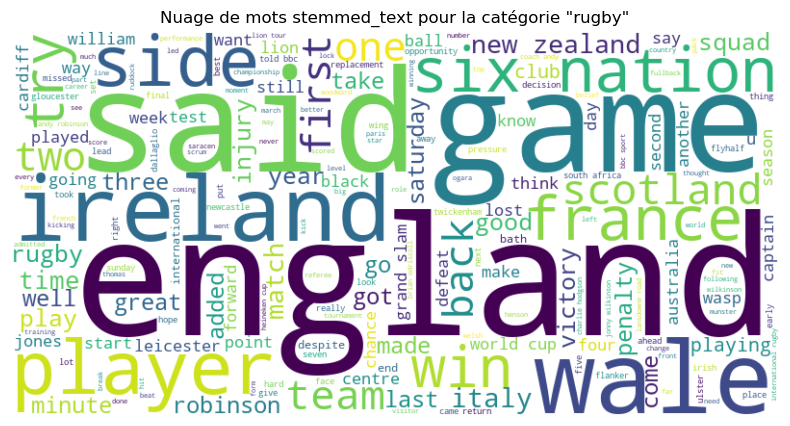

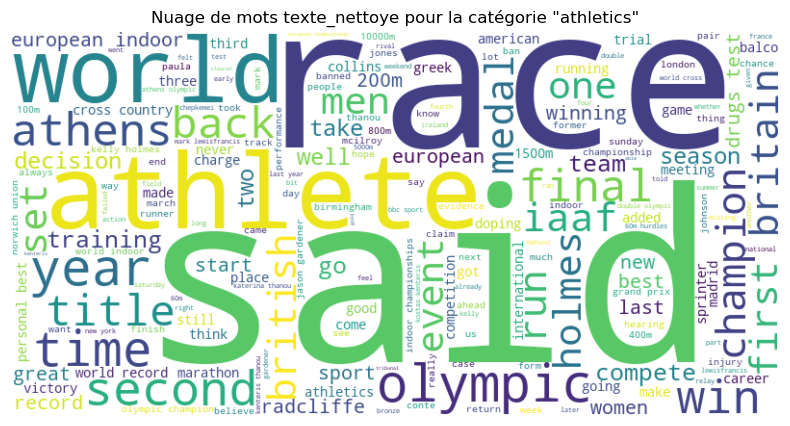

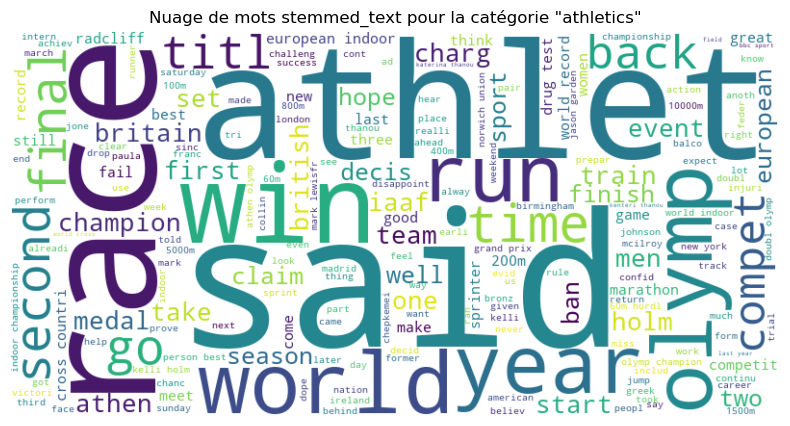

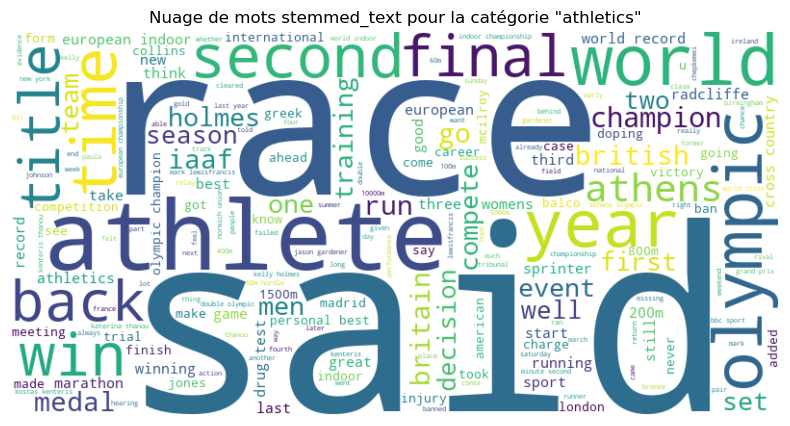

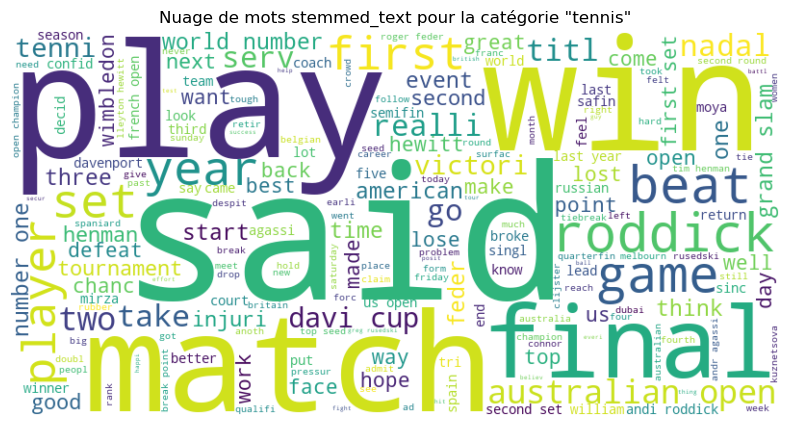

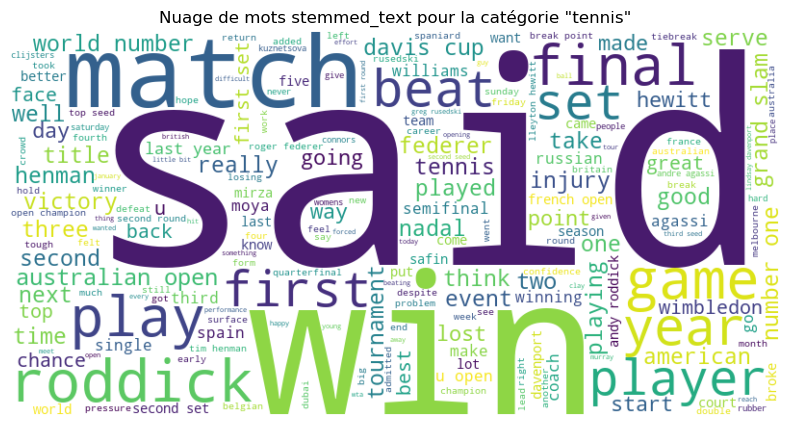

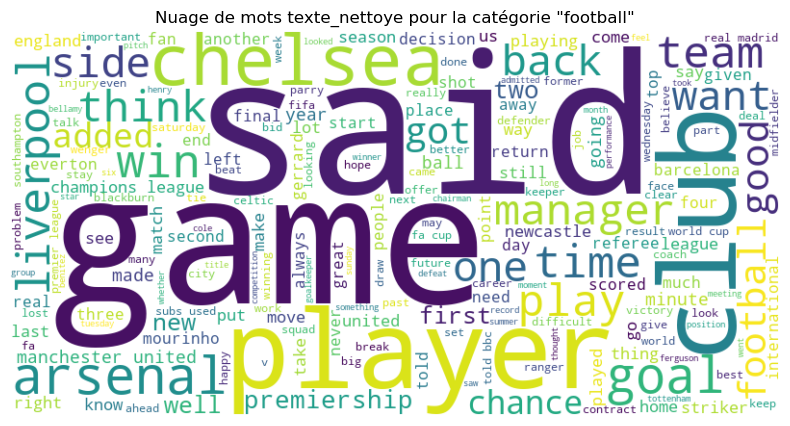

In [551]:
#nuage de mots

from wordcloud import WordCloud

# Générer un nuage de mots pour chaque catégorie
for category in df['sport'].unique():
    texts = " ".join(df[df['sport'] == category]['texte_nettoye'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(texts)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Nuage de mots texte_nettoye pour la catégorie "{category}"')
    plt.axis('off')
    plt.show()
    
    stemmed_text = " ".join(df[df['sport'] == category]['stemmed_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(stemmed_text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Nuage de mots stemmed_text pour la catégorie "{category}"')
    plt.axis('off')
    plt.show()
    
    lemmatized_text_nltk = " ".join(df[df['sport'] == category]['lemmatized_text_nltk'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(lemmatized_text_nltk)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Nuage de mots stemmed_text pour la catégorie "{category}"')
    plt.axis('off')
    plt.show()

    

In [552]:
# statistique numerique

df_numerique = df.select_dtypes(include=['int64', 'float64'])
df_pivot = df_numerique.pivot_table(index=df['sport'], aggfunc='mean')
df_pivot

entropie  longueur_moyenne_mots  longueur_texte  mots_chiffres  \
sport                                                                       
athletics  7.015798               4.861149     1820.515152       1.525253   
cricket    7.354858               4.827645     2210.008264       4.900826   
football   7.129402               4.736127     1958.961832       1.526718   
rugby      7.288221               4.824012     2124.623288       2.006849   
tennis     6.990360               4.648690     1602.939394       2.111111   

           mots_uniques  nombre_majuscules  nombre_ponctuations  \
sport                                                             
athletics    191.535354          53.575758            49.878788   
cricket      236.206612          79.917355            68.727273   
football     206.053435          61.793893            57.786260   
rugby        225.678082          81.726027            71.678082   
tennis       178.454545          51.929293            53.606061   

           num_caracteres_avec_espaces  num_lignes    num_mots  \
sport                                                            
athletics                  1820.515152    4.090909  312.636364   
cricket                    2210.008264    5.471074  381.826446   
football                   1958.961832    4.461832  343.255725   
rugby                      2124.623288    4.739726  366.712329   
tennis                     1602.939394    4.010101  284.686869   

           richesse_lexicale   stopwords  
sport                                     
athletics           0.649331  121.898990  
cricket             0.645068  139.404959  
football            0.631697  138.160305  
rugby               0.638908  138.109589  
tennis              0.660591  106.949495

---

### **1. Entropie**
- Le **cricket** a l'entropie la plus élevée (7.35), ce qui suggère une plus grande diversité lexicale ou une plus grande complexité dans les textes associés à ce sport.
- Le **tennis** a l'entropie la plus faible (6.99), indiquant une moindre diversité lexicale ou une structure textuelle plus simple.

---

### **2. Longueur moyenne des mots**
- Les mots dans les textes liés à l'**athletics** sont en moyenne les plus longs (4.86), tandis que ceux du **tennis** sont les plus courts (4.65).
- Cela pourrait indiquer que les textes sur l'athletics utilisent des termes plus techniques ou spécifiques.

---

### **3. Longueur du texte**
- Les textes sur le **cricket** sont les plus longs (2210), suivis de près par le **rugby** (2124).
- Les textes sur le **tennis** sont les plus courts (1602), ce qui pourrait indiquer des descriptions plus concises ou moins détaillées.

---

### **4. Mots chiffres**
- Le **cricket** utilise beaucoup plus de mots chiffres (4.90), ce qui pourrait refléter l'importance des statistiques (comme les scores, les moyennes, etc.) dans les textes liés à ce sport.
- L'**athletics** et le **football** en utilisent très peu, ce qui suggère que les textes sont moins axés sur les données numériques.

---

### **5. Mots uniques**
- Le **cricket** et le **rugby** ont le plus grand nombre de mots uniques, ce qui confirme une plus grande diversité lexicale.
- Le **tennis** a le moins de mots uniques, ce qui pourrait indiquer un vocabulaire plus restreint ou répétitif.

---

### **6. Nombre de majuscules**
- Le **rugby** et le **cricket** utilisent beaucoup plus de majuscules, ce qui pourrait être dû à l'utilisation fréquente de noms propres (équipes, joueurs, lieux).
- L'**athletics** et le **tennis** en utilisent moins, ce qui pourrait refléter une moindre importance des noms propres.

---

### **7. Nombre de ponctuations**
- Le **rugby** et le **cricket** utilisent plus de ponctuation, ce qui pourrait indiquer des textes plus structurés ou complexes.
- L'**athletics** et le **tennis** en utilisent moins, ce qui pourrait refléter des textes plus simples ou moins formels.

---

### **8. Nombre de caractères (avec espaces)**
- Similaire à la longueur du texte, le **cricket** et le **rugby** ont les textes les plus longs en termes de caractères.
- Le **tennis** a les textes les plus courts.

---

### **9. Nombre de lignes**
- Le **cricket** a le plus grand nombre de lignes par texte, ce qui confirme que les textes sont plus longs et détaillés.
- Le **tennis** a le moins de lignes, ce qui correspond à des textes plus courts.

---

### **10. Nombre de mots**
- Le **cricket** et le **rugby** ont le plus grand nombre de mots, ce qui confirme que leurs textes sont plus longs.
- Le **tennis** a le moins de mots, ce qui correspond à des textes plus courts.

---

### **11. Richesse lexicale**
- Le **tennis** a la richesse lexicale la plus élevée (0.661154), ce qui signifie que les textes utilisent un vocabulaire plus varié par rapport au nombre total de mots.
- Le **football** a la richesse lexicale la plus faible (0.631975), ce qui pourrait indiquer une répétition plus fréquente des mots.

---

### **12. Stopwords**
- Le **cricket** et le **football** utilisent le plus de stopwords, ce qui pourrait indiquer des textes plus descriptifs ou conversationnels.
- Le **tennis** en utilise le moins, ce qui pourrait refléter des textes plus techniques ou concis.

---

### **Synthèse**
- **Cricket** et **Rugby** : Textes plus longs, plus complexes, avec une utilisation importante de majuscules, de ponctuation et de mots chiffres. Cela pourrait refléter des descriptions détaillées, des statistiques ou des analyses.
- **Tennis** : Textes plus courts, moins de diversité lexicale, mais une richesse lexicale plus élevée. Cela pourrait indiquer des descriptions plus techniques ou spécialisées.
- **Athletics** et **Football** : Situés entre les deux, avec des textes de longueur moyenne et une utilisation modérée des caractéristiques analysées.


---

# 5. Modélisation

Application de RandomUnderSampler parce que une classe domine largement et pour éviter un biais. On risque de perdre de l'information.

sport
football     146
rugby        146
cricket      121
athletics     99
tennis        99
Name: count, dtype: int64
Lignes supprimées


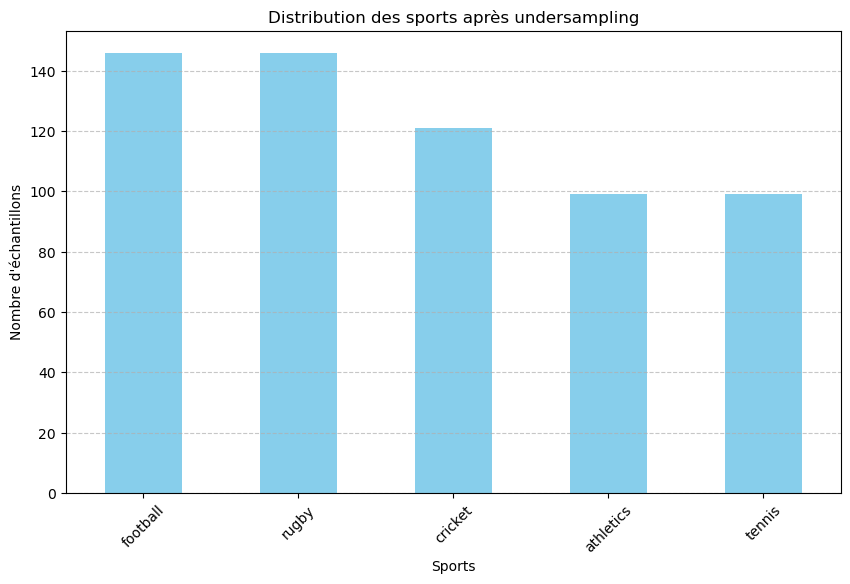

In [553]:
# Sauvegarder les index d'origine
df['original_index'] = df.index

from imblearn.under_sampling import RandomUnderSampler

# Séparer X (features) et y (cible)
X = df.drop(columns=['sport'])
y = df['sport']

# Compter le nombre d'échantillons par classe
class_counts = Counter(y)
sorted_counts = sorted(class_counts.items(), key=lambda x: x[1], reverse=True)

# Trouver la 2ᵉ plus grande catégorie (en taille)
if len(sorted_counts) > 1:
    second_largest_class_size = sorted_counts[1][1]  # Taille de la 2ᵉ classe la plus grande
else:
    second_largest_class_size = sorted_counts[0][1]  # Si une seule classe, on garde la même taille

    
# Définir la stratégie d'échantillonnage (réduire uniquement la catégorie majoritaire)
sampling_strategy = {
    class_label: second_largest_class_size if count == sorted_counts[0][1] else count
    for class_label, count in class_counts.items()
}

# Appliquer le RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

# Reconstruire le DataFrame équilibré
df_resampled = pd.DataFrame(X_resampled, columns=X.columns)
df_resampled['sport'] = y_resampled

# Vérifier la nouvelle distribution
print(df_resampled['sport'].value_counts())

# Lignes supprimées
print("Lignes supprimées")
excluded_rows = df[~df['original_index'].isin(df_resampled['original_index'])]

# Visualisation après undersampling
plt.figure(figsize=(10, 6))
df_resampled['sport'].value_counts().plot(kind='bar', color='skyblue')
plt.xlabel("Sports")
plt.ylabel("Nombre d'échantillons")
plt.title("Distribution des sports après undersampling")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

df = df_resampled.sample(frac=1, random_state=11).reset_index(drop=True)
    



##### Approche 1

Ce code utilise une technique d'extraction de caractéristiques textuelles (TF-IDF Vectors) et applique quatre algorithmes de classification différents : Naive Bayes, Complement Naive Bayes, Régression Logistique et SVM. L'objectif est de comparer les performances de ces modèles en se basant sur la même technique d'extraction. Les étapes principales sont :

1. **Extraction des Caractéristiques** :  
   - Le texte est transformé en vecteurs TF-IDF.  

2. **Classification** :  
   - Cinq modèles sont entraînés et évalués : Naive Bayes, Complement Naive Bayes, Régression Logistique,SVM et Random Forest.  

3. **Comparaison** :  
   - Les performances des modèles sont comparées en utilisant des métriques comme le score F1, accuracy et les temps d'exécution.  

En résumé, ce code permet de comparer cinq modèles de classification en utilisant une technique d'extraction commune (TF-IDF).

In [554]:
def extract_text_features(df, text_column='lemmatized_text_nltk'):
    
    df = df.copy()

    df['text_length'] = df[text_column].apply(lambda x: len(x))
    df['unique_word_count'] = df[text_column].apply(lambda x: len(set(x.split())))
    df['avg_word_length'] = df[text_column].apply(lambda x: sum(len(word) for word in x.split()) / max(len(x.split()), 1))  # Avg word length
    df['short_word_count'] = df[text_column].apply(lambda x: sum(1 for word in x.split() if len(word) < 4))  # Short words (<4 letters)
    df['digit_count'] = df[text_column].apply(lambda x: sum(c.isdigit() for c in x))  # Count of digits
    df['short_word_ratio'] = df['short_word_count'] / df['unique_word_count'].replace(0, 1)  # Ratio of short words
    df['digit_ratio'] = df['digit_count'] / df['text_length'].replace(0, 1)  # Ratio of digits

    return df


X = df[['lemmatized_text_nltk']]
X = extract_text_features(X)
y = df['sport']

X

lemmatized_text_nltk  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             bomb threat bernabeu stadium spectator evacuated real madrid bernabeu stadium sunday following bomb scare game host real sociedad 70000 people abandoned ground score 11 three minute left play basque newspaper gara apparently received telephone call saying bomb due explode 2100 local time searching stadium sniffer dog police said explosive device found police said completed search found anything said real madrid president florentino perez best thing put nightmare behind u madrid midfielder guti told private spanish radio station cadena ser never seen sport real took lead break brazilian striker ronaldo cracked home left foot sociedad levelled match midway second half turkish striker nihat kahveci smashed home acrobatic finish yet clear remaining three minute game played later date result allowed stand result remains 11 real drop third place standing 11 point behind leader barcelona snatched late 21 win albacete saturday initial report suggested basque separatist group eta may responsible bomb threat issuing similar warning series small explosion recent day bernabeu targeted eta 1 may 2002 madrid play fc barcelona champion league semifinal car bomb exploded street outside stadium 17 people slightly injured   
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [555]:
text_column = "lemmatized_text_nltk"
numeric_columns = ['text_length', 'unique_word_count', 'avg_word_length', 'short_word_count', 'digit_count', 'short_word_ratio', 'digit_ratio']
target_column = "sport"

#Séparation des données (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=df[target_column])

#Transformer les features avec TF-IDF et StandardScaler
preprocessor = ColumnTransformer(transformers=[
    ('tfidf', TfidfVectorizer(), text_column),  # TF-IDF sur le texte
    ('num', MinMaxScaler(), numeric_columns)  # StandardScaler sur les features numériques
])


#Définition des modèles
models = {
    "Naive Bayes": MultinomialNB(),
    "Complement Naive Bayes": ComplementNB(),
    "Régression Logistique": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel='linear', probability=True),  # Ajouter `probability=True` pour compatibilité
}

# 🔹 Fonction d'entraînement et de logging MLflow
def train_and_log_model(model_name, model, X_train, X_test, y_train, y_test):
    """
    Entraîne un modèle, évalue ses performances et logge les résultats dans MLflow.
    """
    feature_name = "TF–IDF"
    
    # 🔹 Définition du pipeline complet
    pipeline = Pipeline([
        ('preprocessing', preprocessor),
        ('classifier', model)
    ])

    # 🔹 Entraînement du modèle
    debut_entrainement = time.time()
    pipeline.fit(X_train, y_train)
    temps_entrainement = time.time() - debut_entrainement

    # 🔹 Prédictions
    debut_prediction = time.time()
    y_pred = pipeline.predict(X_test)
    temps_prediction = time.time() - debut_prediction
    
    y_proba = pipeline.predict_proba(X_test) if hasattr(pipeline, "predict_proba") else None

    # 🔹 Calcul des métriques
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="weighted")

    # 🔹 Affichage des résultats
    print(f"\n📊 {model_name} - Rapport de classification :")
    print(classification_report(y_test, y_pred, zero_division=0))
    print(f"\nAccurancy: {accuracy}")
    print(f"\nF1 Score: {f1}")

    # 🔹 Définition de la signature MLflow
    signature = infer_signature(X_test, y_pred)

    # 🔹 Logging dans MLflow
    with mlflow.start_run(run_name=f"{model_name} - {feature_name}"):
        
        mlflow.log_param("dataset lignes", len(X_train) + len(X_test))
        mlflow.log_param("entrainement lignes", X_train.shape[0])
        mlflow.log_param("test_lignes", X_test.shape[0])
        mlflow.log_param("predicteurs", X_train.columns)
        
        mlflow.log_metric("Accuracy", accuracy)
        mlflow.log_metric("F1 Score", f1)
        mlflow.log_metric("Temps entrainement", temps_entrainement)
        mlflow.log_metric("Temps prediction", temps_prediction)
        
        mlflow.sklearn.log_model(pipeline, f"{model_name} - {feature_name}", signature=signature)

    return pipeline

# 🔹 Entraîner et logger chaque modèle
trained_models = {}
for model_name, model in models.items():
    trained_models[model_name] = train_and_log_model(model_name, model, X_train, X_test, y_train, y_test)



📊 Naive Bayes - Rapport de classification :
              precision    recall  f1-score   support

   athletics       1.00      0.85      0.92        20
     cricket       1.00      0.96      0.98        24
    football       1.00      0.97      0.98        30
       rugby       0.78      1.00      0.88        29
      tennis       1.00      0.85      0.92        20

    accuracy                           0.93       123
   macro avg       0.96      0.93      0.94       123
weighted avg       0.95      0.93      0.94       123


Accurancy: 0.9349593495934959

F1 Score: 0.93676823062977

📊 Complement Naive Bayes - Rapport de classification :
              precision    recall  f1-score   support

   athletics       1.00      0.95      0.97        20
     cricket       1.00      1.00      1.00        24
    football       1.00      1.00      1.00        30
       rugby       0.97      1.00      0.98        29
      tennis       1.00      1.00      1.00        20

    accuracy             

# ** Using MLFlow pour predire nouveau texte **

Deux examples de predictions de nouveau texte en utilisant les modeles stockés dans MLFLow

In [556]:
def predict_new_article(text, model_name, experiment_name):
    """
    Prend un nouvel article et prédit sa catégorie de sport avec le modèle MLflow sélectionné.
    """

    #Récupérer l'ID de l'expérience
    experiment = mlflow.get_experiment_by_name(experiment_name)
    if not experiment:
        raise ValueError(f"Expérience '{experiment_name}' introuvable dans MLflow.")

    experiment_id = experiment.experiment_id

    #Trouver le dernier run du modèle
    runs = mlflow.search_runs(experiment_ids=[experiment_id], order_by=["start_time desc"])

    if runs.empty:
        raise ValueError(f"Aucun run trouvé pour '{model_name}' dans l'expérience '{experiment_name}'.")

    #Filtrer les runs qui ont le bon `run_name`
    runs_filtres = runs[runs["tags.mlflow.runName"] == model_name]

    if runs_filtres.empty:
        raise ValueError(f"Aucun run trouvé pour '{model_name}' dans l'expérience '{experiment_name}'.")

    #Récupérer l'ID du dernier run correspondant
    last_run = runs_filtres.iloc[0]
    artifact_uri = last_run["artifact_uri"]  # Récupérer le chemin des artefacts

    #Charger le modèle depuis MLflow
    model_path = f"{artifact_uri}/{model_name}"
    print(f"Chargement du modèle depuis {model_path}")
    pipeline = mlflow.sklearn.load_model(model_path)

    #Créer un DataFrame avec les nouvelles features
    new_data = pd.DataFrame({
        'lemmatized_text_nltk': [text],
        'text_length': [len(text)],
        'unique_word_count': [len(set(text.split()))],
        'avg_word_length': [sum(len(word) for word in text.split()) / max(len(text.split()), 1)],
        'short_word_count': [sum(1 for word in text.split() if len(word) < 4)],
        'digit_count': [sum(c.isdigit() for c in text)],
        'short_word_ratio': [sum(1 for word in text.split() if len(word) < 4) / max(len(set(text.split())), 1)],
        'digit_ratio': [sum(c.isdigit() for c in text) / max(len(text), 1)]
    })

    #Prédiction
    prediction = pipeline.predict(new_data)
    
    print(f"\nTexte analysé : \"{text}\"")
    print(f"Catégorie prédite : {prediction[0]}")
    return prediction[0]

#On prend un article du dataset qu'on avait exclus
new_article_lemmatized = "van nistelrooy set return manchester united striker ruud van nistelrooy may make comeback achilles tendon injury fa cup fifth round tie everton saturday action nearly three month targeted return champion league tie ac milan 23 february manchester united manager sir alex ferguson hinted may back early said chance could involved everton see come training 28yearold training holland ferguson said ruud come back tuesday need assess far training holland perfect satisfied even without van nistelrooy united made 13 win 15 league game 20 derby victory manchester city sunday boosted return dutch international club top scorer season 12 goal played since aggravating injury 30 win west brom 27 november ferguson unhappy van nistelrooy revealing carrying injury united also hit injury alan smith louis saha van nistelrooys absence meaning wayne rooney sometimes play lone role front teenager responded six goal nine game including first goal city sunday"
predict_new_article(new_article_lemmatized, "Random Forest - TF–IDF", "BBC Sports Articles Classification")

new_article_tenis = [{"text":"Katie Boulter was playing in her third tournament of the year. "
               "Britain's Katie Boulter and Cameron Norrie were knocked out of Indian Wells "
               "as they suffered straight-set defeats in the third round. "
               "British women's number one Boulter was beaten 6-0 7-5 by seventh seed Elena Rybakina in California."}]

#Create a DataFrame for preprocessing
df_check = pd.DataFrame(new_article_tenis)

df_check = nettoyer_texte(df_check, "text")
df_check = apply_lemmatization_nltk(df_check, text_column="texte_nettoye", new_column_name="lemmatized_text_nltk")

article_tennis_lemmatized =  str(df_check["lemmatized_text_nltk"].values[0])

predict_new_article(article_tennis_lemmatized, "Random Forest - TF–IDF", "BBC Sports Articles Classification")


Chargement du modèle depuis file:///Users/claudia.abad/Formation%20IA/A56/TPs/TPA56-BbcSports/mlruns/595029885274379098/fb661392cad44714b789f1ee7ceee18c/artifacts/Random Forest - TF–IDF

Texte analysé : "van nistelrooy set return manchester united striker ruud van nistelrooy may make comeback achilles tendon injury fa cup fifth round tie everton saturday action nearly three month targeted return champion league tie ac milan 23 february manchester united manager sir alex ferguson hinted may back early said chance could involved everton see come training 28yearold training holland ferguson said ruud come back tuesday need assess far training holland perfect satisfied even without van nistelrooy united made 13 win 15 league game 20 derby victory manchester city sunday boosted return dutch international club top scorer season 12 goal played since aggravating injury 30 win west brom 27 november ferguson unhappy van nistelrooy revealing carrying injury united also hit injury alan smith louis

'tennis'

### ComplementNB avec 3 tecniques d’extraction de prédicteurs

Ce code applique le modèle **Complement Naive Bayes** sur quatre types de sources de données pour comparer leurs performances. Les étapes principales sont :

1. **Sources de Données** :
   - **Word Count Vectors** : Transformation du texte en vecteurs de comptage de mots avec `CountVectorizer`.
   - **TF-IDF Vectors** : Transformation du texte en vecteurs TF-IDF avec `TfidfVectorizer`.
   - **Word Embeddings** : Utilisation des embeddings de mots générés par spaCy, normalisés avec `MinMaxScaler`.

2. **Évaluation** :
   - Chaque source est évaluée avec **ComplementNB** en utilisant la validation croisée et le score F1 pondéré.
   - Les résultats (F1 Score, temps d'exécution) sont enregistrés dans **MLflow** pour comparaison.

3. **Résultats** :
   - Les performances sont comparées pour chaque source, avec un focus sur le score F1 et les temps d'entraînement/prédiction.

En résumé, ce code permet de comparer l'efficacité de différentes techniques d'extraction de caractéristiques avec **ComplementNB**.

In [557]:
# Convert text data to average word embeddings using spaCy.
def get_word_embeddings(texts):
    
    return np.array([nlp(text).vector for text in texts])

# Train multiple classifiers using both text features (TF-IDF, Word Count, Word Embeddings) and numeric features.
def train_models_with_existing_splits(X_train, X_test, y_train, y_test, numeric_columns, text_column):
    """
    
    Logs results into MLflow.

    Args:
        X_train (pd.DataFrame): Training features
        X_test (pd.DataFrame): Testing features
        y_train (pd.Series): Training labels.
        y_test (pd.Series): Testing labels.
        numeric_columns (list): List of numerical feature column names.
        text_column (str): Name of the text column.

    Returns:
        dict: Dictionary with trained models and results.
    """

    # Feature extraction

    # Word Count Vectors (Bag of Words)
    count_vectorizer = CountVectorizer()
    X_train_count = count_vectorizer.fit_transform(X_train[text_column])
    X_test_count = count_vectorizer.transform(X_test[text_column])

    # TF-IDF Vectors
    tfidf_vectorizer = TfidfVectorizer()
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train[text_column])
    X_test_tfidf = tfidf_vectorizer.transform(X_test[text_column])

    # Word Embeddings (Average Word2Vec via spaCy)
    X_train_embed = get_word_embeddings(X_train[text_column])
    X_test_embed = get_word_embeddings(X_test[text_column])

    # Normalize numerical features
    scaler = MinMaxScaler()
    X_train_numeric = scaler.fit_transform(X_train[numeric_columns])
    X_test_numeric = scaler.transform(X_test[numeric_columns])

    # Define les modeles dictionary
    models = {
        "CatBoost" : CatBoostClassifier(iterations=500, depth=6, learning_rate=0.1, loss_function="MultiClass", verbose=100)
    }

    results = {}

    # Train and evaluate models
    feature_methods = {
        "Word Count Vectors": (X_train_count, X_test_count),
        "TF-IDF": (X_train_tfidf, X_test_tfidf),
        "Word Embeddings": (X_train_embed, X_test_embed),  # ADDED EMBEDDINGS HERE ✅
    }

    for feature_name, (X_train_text, X_test_text) in feature_methods.items():

        # Combine text + numerical features
        if feature_name == "Word Embeddings":
            X_train_combined = np.hstack((X_train_text, X_train_numeric))  # Word Embeddings are already in array format
            X_test_combined = np.hstack((X_test_text, X_test_numeric))
        else:
            X_train_combined = np.hstack((X_train_text.toarray(), X_train_numeric))
            X_test_combined = np.hstack((X_test_text.toarray(), X_test_numeric))

        for model_name, model in models.items():
            print(f"\nModel {model_name} with {feature_name}")

            start_train = time.time()
            model.fit(X_train_combined, y_train)
            train_time = time.time() - start_train

            start_pred = time.time()
            y_pred = model.predict(X_test_combined)
            pred_time = time.time() - start_pred
            
            # Calcul des métriques
            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred, average="weighted")

            # Affichage des résultats
            print(f"\n{model_name} - Rapport de classification :")
            print(classification_report(y_test, y_pred, zero_division=0))
            print(f"\nAccurancy: {accuracy}")
            print(f"\nF1 Score: {f1}")

            # MLflow logging
            signature = infer_signature(X_test_combined, y_pred)

            with mlflow.start_run(run_name=f"{model_name} - {feature_name}"):
                mlflow.log_param("Train Size", X_train.shape[0])
                mlflow.log_param("Test Size", X_test.shape[0])
                mlflow.log_param("Feature Extraction", feature_name)
                mlflow.log_param("Model", model_name)

                mlflow.log_metric("Accuracy", accuracy)
                mlflow.log_metric("F1 Score", f1)
                mlflow.log_metric("Training Time", train_time)
                mlflow.log_metric("Prediction Time", pred_time)

                mlflow.sklearn.log_model(model, f"{model_name} - {feature_name}", signature=signature)

            # Store results
            results[f"{model_name} - {feature_name}"] = {
                "model": model,
                "accuracy": accuracy,
                "f1_score": f1
            }

    return results


In [558]:
model_results = train_models_with_existing_splits(X_train, X_test, y_train, y_test, numeric_columns, text_column)


Model CatBoost with Word Count Vectors
0:	learn: 1.5382829	total: 55.9ms	remaining: 27.9s
100:	learn: 0.1923476	total: 4.7s	remaining: 18.6s
200:	learn: 0.0987337	total: 9.46s	remaining: 14.1s
300:	learn: 0.0644001	total: 14.1s	remaining: 9.34s
400:	learn: 0.0472907	total: 18.7s	remaining: 4.62s
499:	learn: 0.0354507	total: 23.2s	remaining: 0us

CatBoost - Rapport de classification :
              precision    recall  f1-score   support

   athletics       1.00      1.00      1.00        20
     cricket       1.00      1.00      1.00        24
    football       0.97      1.00      0.98        30
       rugby       1.00      0.97      0.98        29
      tennis       1.00      1.00      1.00        20

    accuracy                           0.99       123
   macro avg       0.99      0.99      0.99       123
weighted avg       0.99      0.99      0.99       123


Accurancy: 0.991869918699187

F1 Score: 0.9918652422072107

Model CatBoost with TF-IDF
0:	learn: 1.5280816	total: 128ms	re

In [559]:
!mlflow ui

[2025-03-10 18:21:32 -0400] [47105] [INFO] Starting gunicorn 22.0.0
[2025-03-10 18:21:32 -0400] [47105] [ERROR] Connection in use: ('127.0.0.1', 5000)
[2025-03-10 18:21:32 -0400] [47105] [ERROR] Retrying in 1 second.
[2025-03-10 18:21:33 -0400] [47105] [ERROR] Connection in use: ('127.0.0.1', 5000)
[2025-03-10 18:21:33 -0400] [47105] [ERROR] Retrying in 1 second.
[2025-03-10 18:21:34 -0400] [47105] [ERROR] Connection in use: ('127.0.0.1', 5000)
[2025-03-10 18:21:34 -0400] [47105] [ERROR] Retrying in 1 second.
[2025-03-10 18:21:35 -0400] [47105] [ERROR] Connection in use: ('127.0.0.1', 5000)
[2025-03-10 18:21:35 -0400] [47105] [ERROR] Retrying in 1 second.
[2025-03-10 18:21:36 -0400] [47105] [ERROR] Connection in use: ('127.0.0.1', 5000)
[2025-03-10 18:21:36 -0400] [47105] [ERROR] Retrying in 1 second.
[2025-03-10 18:21:37 -0400] [47105] [ERROR] Can't connect to ('127.0.0.1', 5000)
Running the mlflow server failed. Please see the logs above for details.
